## Synthetic String Optimization

Task:

Given a **goal** string, the LLM must come up with an **input** string that will get to the goal string (through a series of hidden string transformations).

Usage guide:
1. NumericalProgramSampler initialization defines the random search space for the program (but it does NOT generate the program)
   - `program = NumericalProgramSampler(chain_length=3, logic_prob=0, max_gen_var=2)`
   - This only defines a class of problems
   - `param_num` defines how many inputs it takes in.
   - `program.goal_input`: this is the correct answer for LLM to guess (LLM can't see this)
   - `program.goal_output`: this is the target goal (LLM can see this)
   - `program.display_computation_graph()`: shows the computation graph (calling backprop under the hood)
3. Sample a problem from the problem space:
   - `output = program(inpt, seed=3232)`
   - We currently use `seed` to uniquely specify a program. The same seed means regardless of input, it will go through the same program.
   - Different seed means different programs


### Trace Example

In [2]:
from string_synthetic import StringProgramSampler
from opto.trace.nodes import node
from opto.trace.nodes import GRAPH
from opto.trace.propagators import FunctionPropagator

In [3]:
program = StringProgramSampler(chain_length=5, max_gen_var=5, seed=1234, param_num=1, verbose=True)

Op: title Vars from:  [False]
Op: replace Vars from:  [False, False, True]
Op: capitalize Vars from:  [False]
Op: concat Vars from:  [False, True]
Op: concat Vars from:  [False, True]


In [9]:
program.goal_input

['LcQSf']

In [4]:
program.goal_output

'LcqsfXX'

In [5]:
y = program(node('LcqsfXX', "node_x"), seed=1234)

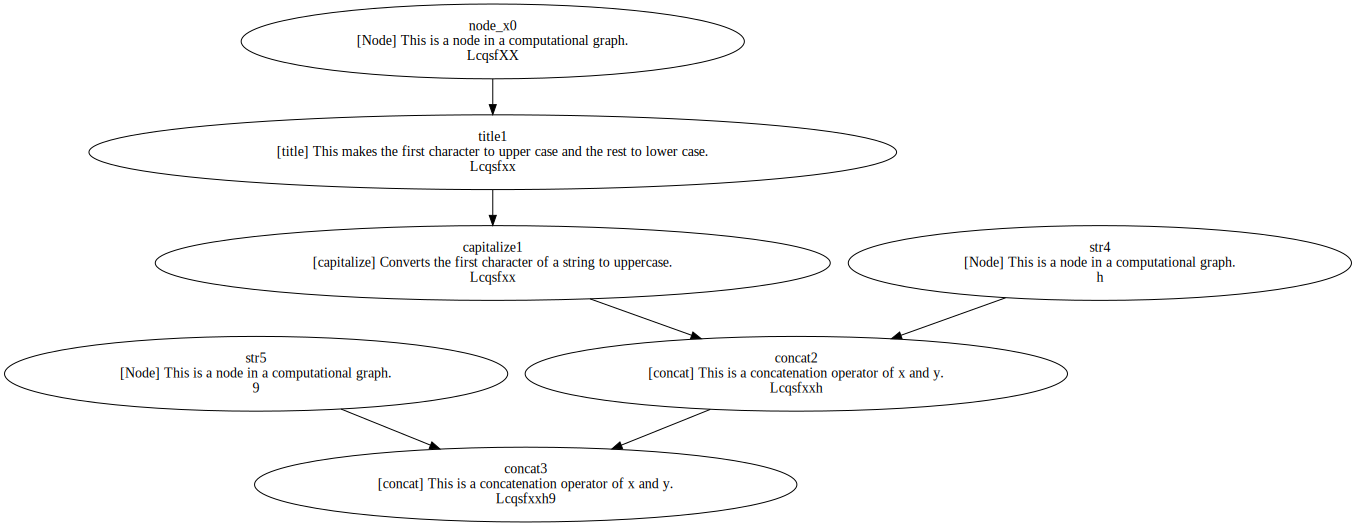

In [6]:
y.backward(visualize=True, feedback="Correct", propagate=FunctionPropagator())

In [8]:
y.data

'Lcqsfxxh9'

## Optimization Loop Example

In [1]:
import autogen
from string_synthetic import StringProgramSampler
from opto.trace.nodes import node
from opto.trace.nodes import GRAPH
from opto.optimizers import FunctionOptimizer

In [2]:
program = StringProgramSampler(chain_length=5, max_gen_var=5, seed=1234, param_num=1, verbose=True)

Op: title Vars from:  [False]
Op: replace Vars from:  [False, False, True]
Op: capitalize Vars from:  [False]
Op: capitalize Vars from:  [False]
Op: swapcase Vars from:  [False]


In [2]:
GRAPH.clear()

program = StringProgramSampler(chain_length=5, param_num=1, max_gen_var=5, seed=1234)
print("Ground truth goal input", program.goal_input)
print("Target output:", program.goal_output)

x = node('aaaaa', "input_x", trainable=True)

optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

history = [x.data]
feedback = ""
for i in range(10):
    print(f"optimization {i}")
    if feedback.lower() == "Success.".lower():
        break
    output = program(x, seed=1234)
    feedback = program.feedback(output.data)
    
    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    print(f"variable={x.data}, output={output.data}, feedback={feedback}")  # logging
    optimizer.step()
    
    history.append(x.data)  # logging

print("History")
for i, v in enumerate(history):
    print(f"  {i}: {v}")

Ground truth goal input ['LcQSf']
Target output: lCQSF
optimization 0
variable=aaaaa, output=aAAAA, feedback=The target string is lCQSF, and the current output from your chosen input is aAAAA
optimization 1
variable=Lcqsf, output=lCQSF, feedback=Success.
optimization 2
History
  0: aaaaa
  1: Lcqsf
  2: Lcqsf
